In [15]:
import os
import subprocess
import json
import glob
import re
import pandas as pd
from collections import defaultdict
from forbiditerative import planners
from pathlib import Path

import matplotlib.pyplot as plt

# Define paths
DOMAINS_PATH = "data/domains"
PROBLEMS_PATH = "data/gen_problems/testing"
KSTAR_PATH = "submodules/kstar"
OUTPUT_DIR = "landmarks_output"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_domain_name(domain_path):
    """Extract domain name from path"""
    return os.path.basename(os.path.dirname(domain_path))

def generate_landmarks(domain_file, problem_file, output_file):
    try:
        domain_path = Path(domain_file)
        problem_path = Path(problem_file)
        # Get exhaustive landmarks using the built-in landmark method
        landmarks = planners.get_landmarks(
            domain_file=domain_path, 
            problem_file=problem_path, 
            method='exhaust'
        )
        # Save the landmarks data to the output file in JSON format
        with open(output_file, 'w') as f:
            json.dump(landmarks, f)
        return True
    except Exception as e:
        print(f"Error generating landmarks for {problem_file}: {e}")
        return False

# Find all domain and problem files
all_data = []
domain_files = glob.glob(f"{DOMAINS_PATH}/*/ground.pddl")

for domain_file in domain_files:
    domain_name = extract_domain_name(domain_file)
    # Look for problems like problem-1.pddl, problem-2.pddl, problem-3.pddl, etc.
    problem_pattern = os.path.join(PROBLEMS_PATH, domain_name, "problem-*.pddl")
    problem_files = glob.glob(problem_pattern)
    
    # # If no problems found, try looking in a subdirectory with the domain name
    # if not problem_files:
    #     problem_pattern = os.path.join(PROBLEMS_PATH, domain_name, domain_name, "p*.pddl")
    #     problem_files = glob.glob(problem_pattern)
    
    # If still no problems found, print a warning
    if not problem_files:
        print(f"Warning: No problem files found for domain {domain_name}")
    
    print(f"Processing domain: {domain_name} with {len(problem_files)} problems")
    
    domain_landmarks = []
    
    for problem_file in problem_files:
        problem_name = os.path.basename(problem_file)
        output_file = f"{OUTPUT_DIR}/{domain_name}_{problem_name.replace('.pddl', '.json')}"
        
        success = generate_landmarks(domain_file, problem_file, output_file)
        
        if success and os.path.exists(output_file):
            with open(output_file, 'r') as f:
                try:
                    landmark_data = json.load(f)
                    
                    # Extract problem number
                    problem_num = int(re.search(r'problem-(\d+)', problem_name).group(1))
                    
                    # Store landmark data
                    domain_landmarks.append({
                        'domain': domain_name,
                        'problem': problem_name,
                        'problem_num': problem_num,
                        'num_landmarks': len(landmark_data['landmarks']),
                        'landmarks': landmark_data['landmarks'],
                    })
                    
                except json.JSONDecodeError:
                    print(f"Error parsing JSON from {output_file}")
    
    all_data.extend(domain_landmarks)



Processing domain: flow with 10 problems
Processing domain: blocks with 10 problems
Processing domain: miconic with 10 problems
Processing domain: bookseller with 10 problems
Processing domain: checkers-jumping with 10 problems


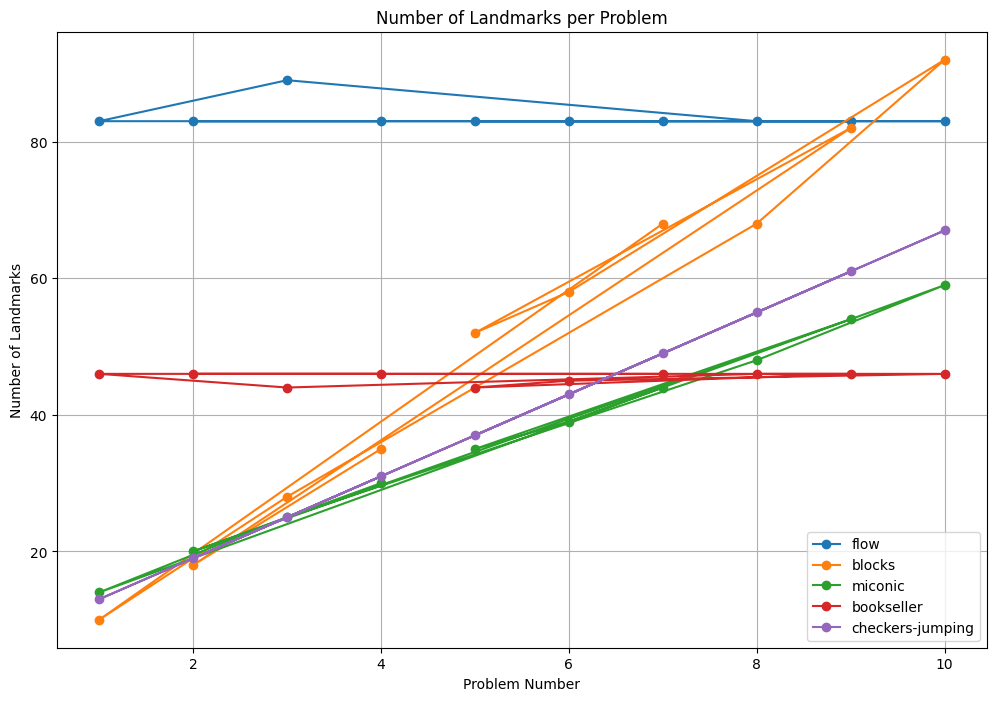

KeyError: 'num_orderings'

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_data)

# Visualize landmark data
if not df.empty:
    # Plot 1: Number of landmarks per problem for each domain
    plt.figure(figsize=(12, 8))
    domains = df['domain'].unique()
    
    for domain in domains:
        domain_data = df[df['domain'] == domain]
        plt.plot(domain_data['problem_num'], domain_data['num_landmarks'], 'o-', label=domain)
    
    plt.xlabel('Problem Number')
    plt.ylabel('Number of Landmarks')
    plt.title('Number of Landmarks per Problem')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{OUTPUT_DIR}/landmarks_per_problem.png")
    plt.show()
    
    # Plot 2: Number of orderings per problem for each domain
    plt.figure(figsize=(12, 8))
    
    # Plot 3: Ratio of orderings to landmarks
    plt.figure(figsize=(12, 8))
    
    # Print some example landmarks for each domain
    print("\nExample Landmarks:")
    for domain in domains:
        domain_data = df[df['domain'] == domain].iloc[0]
        print(f"\nDomain: {domain}")
        print(f"Problem: {domain_data['problem']}")
        print(f"Total Landmarks: {domain_data['num_landmarks']}")
        
        # Print first 5 landmarks (or fewer if there aren't 5)
        num_examples = min(5, len(domain_data['landmarks']))
        for i in range(num_examples):
            print(f"  Landmark {i+1}: {domain_data['landmarks'][i]}")
else:
    print("No landmark data was generated.")